# Tp2. Visión por computadora

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las camaras digitales modernas.

El video a procesar será: **"focus_video.mov"**

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el papper **"Image Sharpness Measure for Blurred Images in Frequency Domain"** y realizar tres experimentos:
* Medición en todo el frame.
* Medición sobre un ROI ubicada en el centro del frame. Área de la ROI = 5 o 10% del total del frame.
* Medición de una matriz de enfoque compuesta por un arreglo de **NxM** elementos rectangulares equiespaciados. **N** y **M** son valores arbitrarios, probar con varios valores 3x3,7x5, etc. (al menos 3)

Para cada experimento se debe presentar:

* Una curva o varias curvas que muestren la evolución de la métrica frame por frame donde se vea claramente cuando el algoritmo detecta el punto de máximo enfoque.

* Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frame donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: **Analysis of focus measure operators in shapeform focus**.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [1]:
import numpy as np
import cv2
from math import log10, sqrt
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output
import time

# Definición de funciones auxiliares.

* Medida de calidad de imagen (**"Image Sharpness Measure for Blurred Images in Frequency Domain"**)

In [2]:
# Función de computo de la calidad de imagen
def quality_measure_simple(image, roi=None ,th=None):
  """Calcula la transformada de Fourier de la imagen."""

  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  if roi is not None:
    x, y, width, height = roi

    image = img[y:y+height, x:x+width]

  else:
    image = image

  fourier = np.fft.fft2(image)
  fourier_centered = np.fft.fftshift(fourier)
  fourier_centered_abs =np.abs(fourier_centered)
  fourier_centered_abs_max = np.max(fourier_centered_abs)

  if th is None:
    threshold = fourier_centered_abs_max / 1000
  else:
      threshold = th
  num_pixels_over_threshold = np.sum(fourier_centered_abs > threshold)

  qimg = num_pixels_over_threshold / (image.shape[0]*image.shape[1])

  return qimg

In [3]:
def quality_measure(image, roi_percent=None, roi_size=None, th=None, metric="FD"):
    """Calcula la transformada de Fourier de la imagen."""

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if roi_percent is not None:
        # Calcular la ROI basada en un porcentaje del centro del frame
        height, width = img.shape[:2]
        roi_width = int(width * roi_percent)
        roi_height = int(height * roi_percent)
        x = (width - roi_width) // 2
        y = (height - roi_height) // 2
        roi = (x, y, roi_width, roi_height)
    elif roi_size is not None:
        # Calcular la ROI basada en una matriz NxM
        roi_width, roi_height = roi_size
        x = (img.shape[1] - roi_width) // 2
        y = (img.shape[0] - roi_height) // 2
        roi = (x, y, roi_width, roi_height)
    else:
        roi = None

    if roi is not None:
        x, y, width, height = roi
        image = img[y:y+height, x:x+width]
    else:
        image = img

    if metric == "FD":

      fourier = np.fft.fft2(image)
      fourier_centered = np.fft.fftshift(fourier)
      fourier_centered_abs = np.abs(fourier_centered)
      fourier_centered_abs_max = np.max(fourier_centered_abs)

      if th is None:
          threshold = fourier_centered_abs_max / 1000
      else:
          threshold = th
      num_pixels_over_threshold = np.sum(fourier_centered_abs > threshold)

      res = num_pixels_over_threshold / (image.shape[0]*image.shape[1])

    else:
      res = variance_of_laplacian(image)

    return  round(res, 4)

# Implementación de la solución

Atendiendo a la consigna se realizará el primer experimento para medir la calidad de enfoque frame por frame sobre todo el frame. Se utilizará el video focus_video.mov como source. El primer punto requiere la utlización de la función auxiliar

In [4]:
def process_video(video_path):

  """
  Esta función mide el enfoque frame por frame

  inputs:
  video_path -> ruta del video

  outputs:
  quentity_measure_list -> lista con las medidas de calidad de cada frame
  frames_count -> total de frames procesados
  """
  cap = cv2.VideoCapture(video_path)

  if not cap.isOpened():

    print("Error abriendo el archivo")
    return []

  quality_measures = []
  frame_count = 0

  while True:

    ret, frame = cap.read()

    if not ret:
      break

    quality = quality_measure(frame)
    quality_measures.append(quality)

    #cv2_imshow(frame)
    #clear_output(wait=True)

    time.sleep(0.03)
    frame_count += 1

    cap.release()
    return quality_measures, frame_count



def plot_quality_measures(quality_measures):
  """
  Grafica de la evolución de la médida de los focos

  inputs: quality_measures -> lista con las medidas de calidad de cada frame

  outputs:
  figure con el gráfico
  """
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(quality_measures)), quality_measures)
  plt.title("Medición de Calidad de Frames")
  plt.xlabel("Frame")
  plt.ylabel("Médida de calidad")
  plt.grid(True)

  max_quality = max(quality_measures)
  max_frame = quality_measures.index(max_quality)
  plt.scatter(max_frame, max_quality, color='red', s=100, zorder=5)
  plt.annotate(f"Max: {max_quality:.4f}", (max_frame, max_quality), xytext=(5, 5),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.axvline(x=max_frame, color='r', linestyle='--', label='Frame con calidad máxima')
  plt.text(max_frame, 0, f"Frame {max_frame}", ha='center', va='top', fontsize=10, color='red')
  plt.legend()

  plt.show()

In [5]:
def highlight_roi(frame, quality_measure_metric, th, roi_size=None, roi_percentage=None, metric="FD"):
    """
    Highlights dibuja el rectángulo que resalta el área de interés
    inputs:
    frame -> sobre el cual se superpondrá la figura
    quality_measure_metric -> valor de la métrica de calidad
    roi_size -> tupla con el ancho y alto de la ROI
    roi_percentage -> porcentaje del frame que será resaltado

    outputs:
    frame -> frame con el rectángulo resaltado
    """
    height, width, _ = frame.shape

    if roi_size is not None:
        if isinstance(roi_size, tuple):
            roi_width, roi_height = roi_size
        else:
            roi_width = int(width * roi_size)
            roi_height = int(height * roi_size)
        roi_x = (width - roi_width) // 2
        roi_y = (height - roi_height) // 2
    elif roi_percentage is not None:
        roi_height = int(height * roi_percentage)
        roi_width = int(width * roi_percentage)
        roi_x = (width - roi_width) // 2
        roi_y = (height - roi_height) // 2
    else:
        roi_x, roi_y, roi_width, roi_height = 0, 0, width, height

    # Determina el color del ROI rectangulo basado en la médida de calidad
    if quality_measure_metric < th:
        color = (0, 0, 255)
    else:
        color = (0, 255, 0)

    # Dibuja el rectángulo del ROI
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), color, 2)
    cv2.putText(frame, f"Medida de enfoque: {quality_measure_metric:.4f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return frame

def process_video_roi(video_path, roi_percentage=None, roi_size=None, metric="FD") -> list:
  """
  Esta función mide el enfoque frame por frame

  inputs:
  video_path -> ruta del video
  roi_percentage -> porcentaje del frame que será resaltado
  roi_size -> tamaño de la ROI en pixels (width, height)

  outputs:
  quentity_measure_list -> lista con las medidas de calidad de cada frame
  frames_count -> total de frames procesados

  """
  # Captura el video
  cap = cv2.VideoCapture(video_path)
  #fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  #out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

  # Verifica que se cargue correctamente el archivo
  if not cap.isOpened():
      print("Error al intentar acceder al video.")
      return []

  # Inicializa la lista para las medidas de foco
  quality_measure_list = []

  frames_count = 0

  while True:
      # Obtiene el frame
      ret, frame = cap.read()

      # Sale del While si no hay mas frames
      if not ret:
          break
      if metric == "FD":
        # Calcula la métrica de foco
        quality_measure_metric = quality_measure(frame, roi_percentage, roi_size)
      else:
        # Calcula la métrica de foco
        quality_measure_metric = quality_measure(frame, roi_percentage, roi_size, metric="LP")

      # Lo agrega a la lista
      quality_measure_list.append(quality_measure_metric)

      # Display the frame
      #if roi_percentage or roi_size:
          # Display the frame with the ROI highlighted
       #   frame_roi = highlight_roi(frame, quality_measure_metric, roi_percentage, roi_size, metric=metric)
          #cv2_imshow(frame_roi)
      #else:
          # Muestra el frame
          #cv2_imshow(frame)
      #out.write(frame

      frames_count += 1

  # Release the capture
  cap.release()

  return quality_measure_list, frames_count


In [6]:
def process_video_roi_movie(video_path, file_name, th,roi_percentage=None, roi_size=None, metric="FD") -> list:
  """
  Esta función mide el enfoque frame por frame y genera un video que hace el seguimiento al ROI

  inputs:
  video_path -> ruta del video
  file_name -> nombre del video de salida
  roi_percentage -> porcentaje del frame que será resaltado
  roi_size -> tamaño de la ROI en pixels (width, height)

  outputs:
  quality_measure_list -> lista con las medidas de calidad de cada frame
  frames_count -> total de frames procesados
  video en formato avi.
    """
  # Captura el video
  cap = cv2.VideoCapture(video_path)
  output_path=f"/content/sample_data/{file_name}.avi"
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_path, fourcc, 24.0, (int(cap.get(3)), int(cap.get(4))))

  # Verifica que se cargue correctamente el archivo
  if not cap.isOpened():
      print("Error al intentar acceder al video.")
      return []

  # Inicializa la lista para las medidas de foco
  quality_measure_list = []

  frames_count = 0

  while True:
      # Obtiene el frame
      ret, frame = cap.read()
      # Sale del While si no hay mas frames
      if not ret:
          break

      # Calcula la métrica de foco
      if metric != "FD":
        quality_measure_metric = quality_measure(frame, roi_percentage, roi_size, metric="LP")
      else:
        quality_measure_metric = quality_measure(frame, roi_percentage, roi_size)

      # Lo agrega a la lista
      quality_measure_list.append(quality_measure_metric)

      # Display the frame
      if roi_percentage or roi_size:
          # Display the frame with the ROI highlighted
          frame_roi = highlight_roi(frame, quality_measure_metric, th, roi_percentage, roi_size)
          #cv2_imshow(frame_roi)
      #else:
          # Muestra el frame
          #cv2_imshow(frame)
      out.write(frame)


   # Release the capture
  cap.release()
  out.release()



Medida alternativa de medición de foco

In [7]:
def variance_of_laplacian(image):

  """
  This function calculates the Variance of Laplacian (LAP4) focus measure of an image.

  inputs:
  image: La imagen a evaluar .

  Output:
  Varianza del operador Laplaciano de la imagen.
  """
  return cv2.Laplacian(image, cv2.CV_64F).var()

# Inicio de los ensayos

En primer lugar y para dar inicio a los ensayos de medición de foco, definimos la ruta path del video y hacemos uso de las funciones auxiliares en la parte superior para medir la calidad focal de la imagen (frame por frame).

# Medición para tode el frame.

In [8]:
# Ruta de acceso del archivo de video
video_path = "/content/sample_data/focus_video.mov"

In [9]:
# Preparación para el análisis de la situación de la calidad de foco en los frames
quality_measures, total_frames = process_video_roi(video_path)
max_quality = max(quality_measures)
max_frame = quality_measures.index(max_quality)
print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {total_frames}")
print(f"Valor máximo de la métrica: {max_quality:.4f}")
print(f"Alcanzado en el frame: {max_frame}")

print("===================================================")

Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 0.0286
Alcanzado en el frame: 109


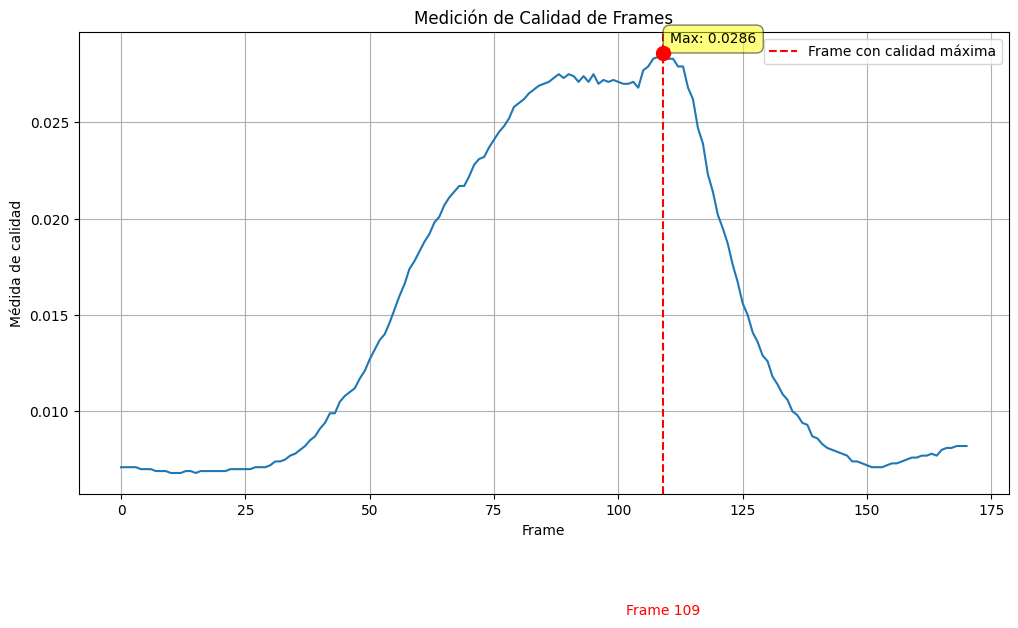

In [10]:
plot_quality_measures(quality_measures)

# Medida del foco para una zona de interés predeterminada

Como porcentaje del punto central (**5%**)

In [11]:
roi_percentage = 0.05
measurements_with_roi, frame = process_video_roi(video_path, roi_percentage=roi_percentage)

In [12]:
print(f"Total de frames procesados: {len(measurements_with_roi)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_roi)
# Retorno del indice
max_focus_idx = measurements_with_roi.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx:.4f}")

print("===================================================")


Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 0.9410
Alcanzado en el frame: 95.0000


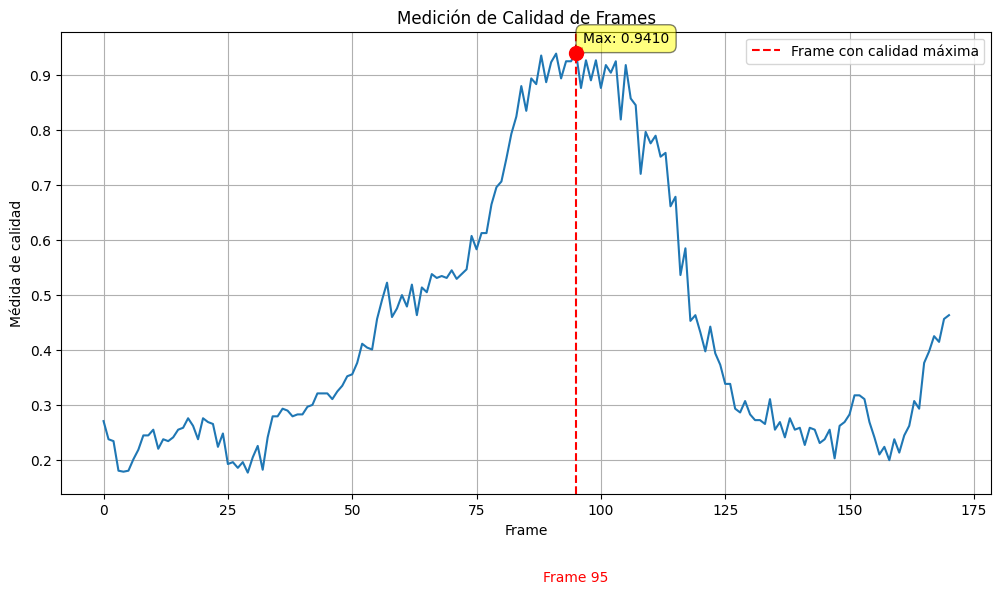

In [13]:
plot_quality_measures(measurements_with_roi)

Para este primer ensayo es posible evidenciar que el valor máximo para la calidad del foco es **0,9410** y este valor se alcanza el frame **95**.

In [14]:
process_video_roi_movie(video_path, file_name="ROI_CENTER_5PCT", th=0.8, roi_percentage=0.05)

Área de interés **10%** (**roi_percentage=0,10**)

In [15]:
roi_percentage = 0.10
measurements_with_roi, frame = process_video_roi(video_path, roi_percentage=roi_percentage)

In [16]:
print(f"Total de frames procesados: {len(measurements_with_roi)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_roi)
# Retorno del indice
max_focus_idx = measurements_with_roi.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx:.4f}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 0.7387
Alcanzado en el frame: 91.0000


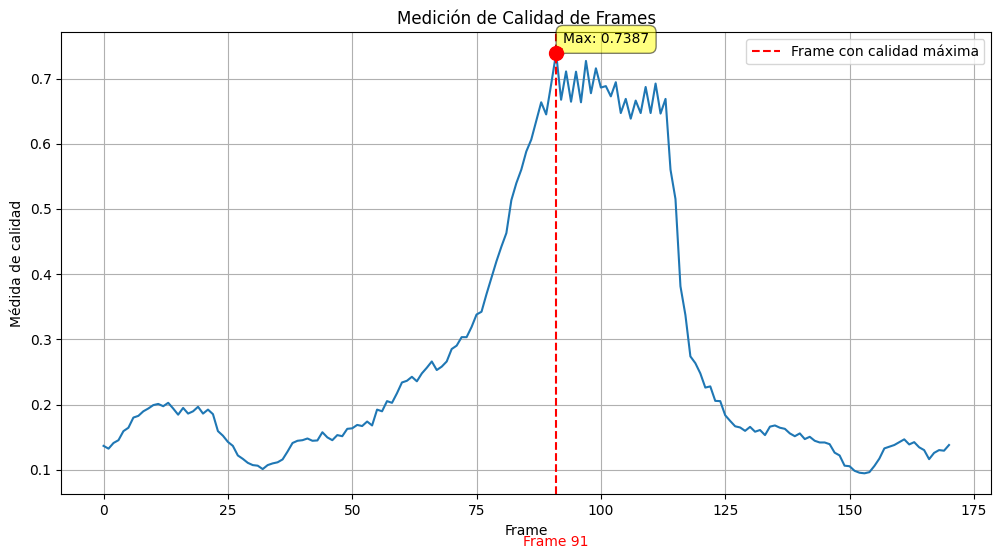

In [17]:
plot_quality_measures(measurements_with_roi)

Para este segundo ensayo, el valor máximo del foco es **0,7387** y se alcanza en el frame **91**.

In [18]:
# Generación del video

process_video_roi_movie(video_path, file_name="ROI_CENTER_10PCT", th=0.65,roi_percentage=0.10)

# Medida del foco con una zona de interés

Medición sobre una matriz de dimensión NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3).



In [19]:
roi_size_1 = (3,3)
measurements_with_reticula_3x3, frame = process_video_roi(video_path, roi_size=roi_size_1)

In [20]:
print(f"Total de frames procesados: {frame}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_3x3)
# Retorno del indice
max_focus_idx = measurements_with_reticula_3x3.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1.0000
Alcanzado en el frame: 0


In [21]:
roi_size_2 = (7,5)
measurements_with_reticula_7x5, frame = process_video_roi(video_path, roi_size=roi_size_2)

In [22]:
print(f"Total de frames procesados: {len(measurements_with_reticula_7x5)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_7x5)
# Retorno del indice
max_focus_idx = measurements_with_reticula_7x5.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1.0000
Alcanzado en el frame: 20


In [23]:
roi_size_3 = (9,12)
measurements_with_reticula_9x12, frame = process_video_roi(video_path, roi_size=roi_size_3)

In [24]:
print(f"Total de frames procesados: {len(measurements_with_reticula_9x12)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_9x12)
# Retorno del indice
max_focus_idx = measurements_with_reticula_9x12.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1.0000
Alcanzado en el frame: 81


In [25]:
roi_size_4 = (25,20)
measurements_with_reticula_25x20, frame = process_video_roi(video_path, roi_size=roi_size_1)

In [26]:
print(f"Total de frames procesados: {len(measurements_with_reticula_25x20)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_25x20)
# Retorno del indice
max_focus_idx = measurements_with_reticula_25x20.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1.0000
Alcanzado en el frame: 0


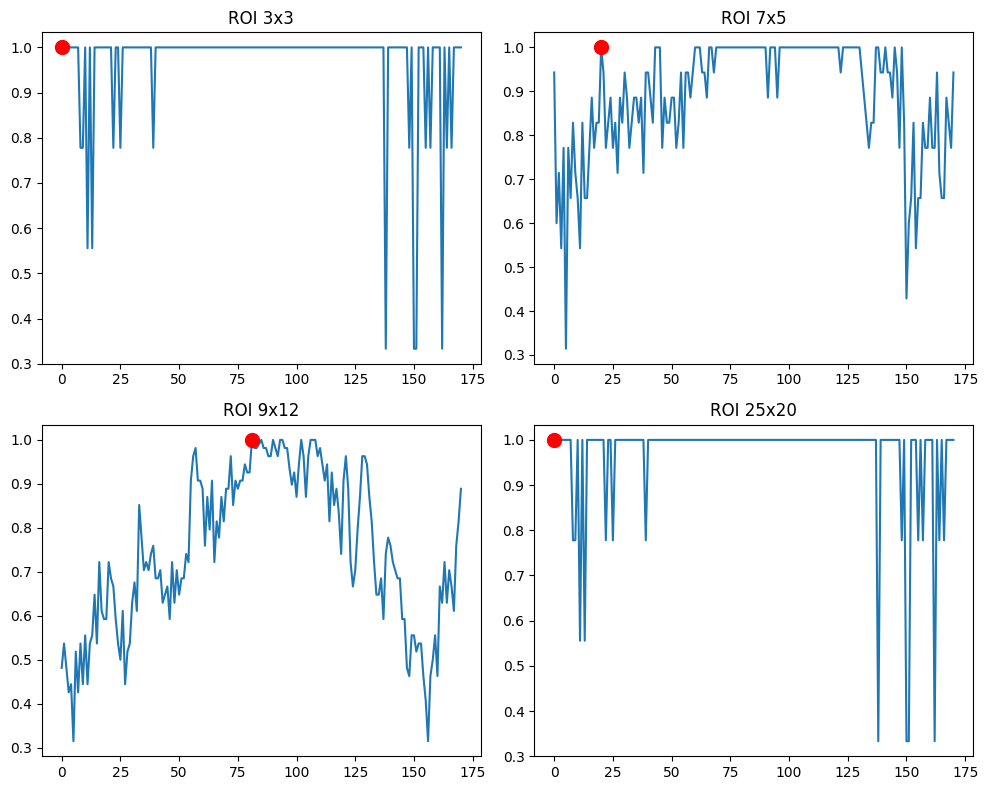

In [27]:
data = [measurements_with_reticula_3x3, measurements_with_reticula_7x5, \
        measurements_with_reticula_9x12, measurements_with_reticula_25x20]
max_value = [max(i) for i in data]
max_frame = [i.index(m) for i, m in zip(data, max_value)]

# Preparación del figure para el gráfico
fig, ax = plt.subplots(2,2, figsize=(10, 8))

ax[0, 0].plot(range(171), measurements_with_reticula_3x3)
ax[0, 0].scatter(max_frame[0], max_value[0], color='red', s=100, zorder=5)
ax[0, 0].set_title("ROI 3x3")
ax[0, 1].plot(range(171), measurements_with_reticula_7x5)
ax[0, 1].scatter(max_frame[1], max_value[1], color='red', s=100, zorder=5)
ax[0, 1].set_title("ROI 7x5")
ax[1, 0].plot(range(171), measurements_with_reticula_9x12)
ax[1, 0].scatter(max_frame[2], max_value[2], color='red', s=100, zorder=5)
ax[1, 0].set_title("ROI 9x12")
ax[1, 1].plot(range(171), measurements_with_reticula_25x20)
ax[1, 1].scatter(max_frame[3], max_value[3], color='red', s=100, zorder=5)
ax[1, 1].set_title("ROI 25x20")

plt.tight_layout()

plt.show()


Es evidente que el cálculo se ve afectado si se varia el área de interés (ROI).

# Ensayos utilizando el Laplaciano como médida de enfoque alternativa.

La consigna solicita el cambio de la métrica de enfoque, para lo cual se eligió la Varianza del Laplaciano (**LAP4
 fuente: Analysis of focus measure operators in shapefrom focus.**)

A continuación se presenta la experimentación con el algoritmo Variance of Laplacian (LAP4).

Todo el frame

In [28]:
# Preparación para el análisis de la situación de la calidad de foco en los frames
quality_measures, total_frames = process_video_roi(video_path, metric="LP")
max_quality = max(quality_measures)
max_frame = quality_measures.index(max_quality)
print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {total_frames}")
print(f"Valor máximo de la métrica: {max_quality:.4f}")
print(f"Alcanzado en el frame: {max_frame}")

print("===================================================")

Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 108.9272
Alcanzado en el frame: 111


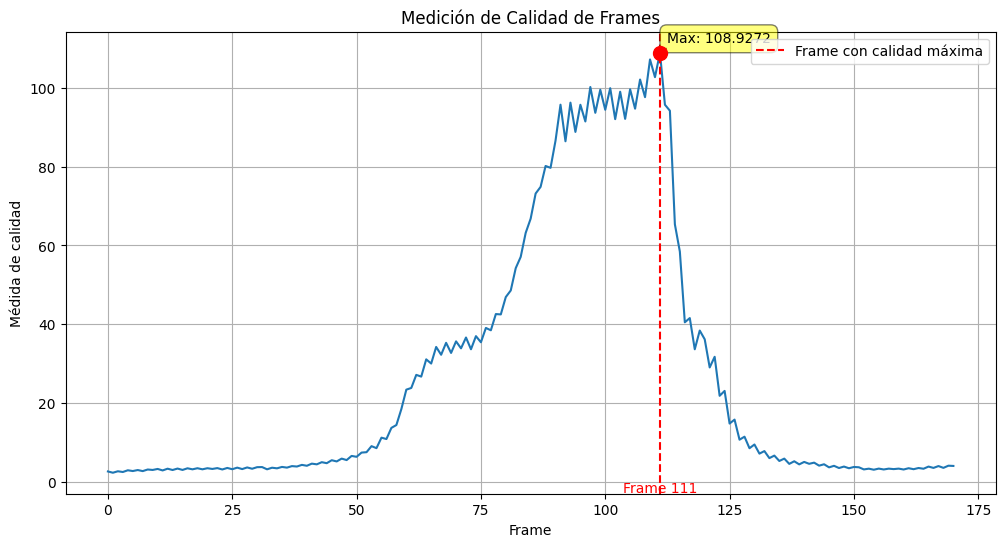

In [29]:
plot_quality_measures(quality_measures)

# Medida del foco para una zona de interés predeterminada

Como porcentaje del punto central (5%)



In [30]:
roi_percentage = 0.05
measurements_with_roi, frame = process_video_roi(video_path, roi_percentage=roi_percentage, metric="LP")

In [31]:
max_quality = max(measurements_with_roi)
max_frame = measurements_with_roi.index(max_quality)
print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_quality:.4f}")
print(f"Alcanzado en el frame: {max_frame}")

print("===================================================")

Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1240.0468
Alcanzado en el frame: 97


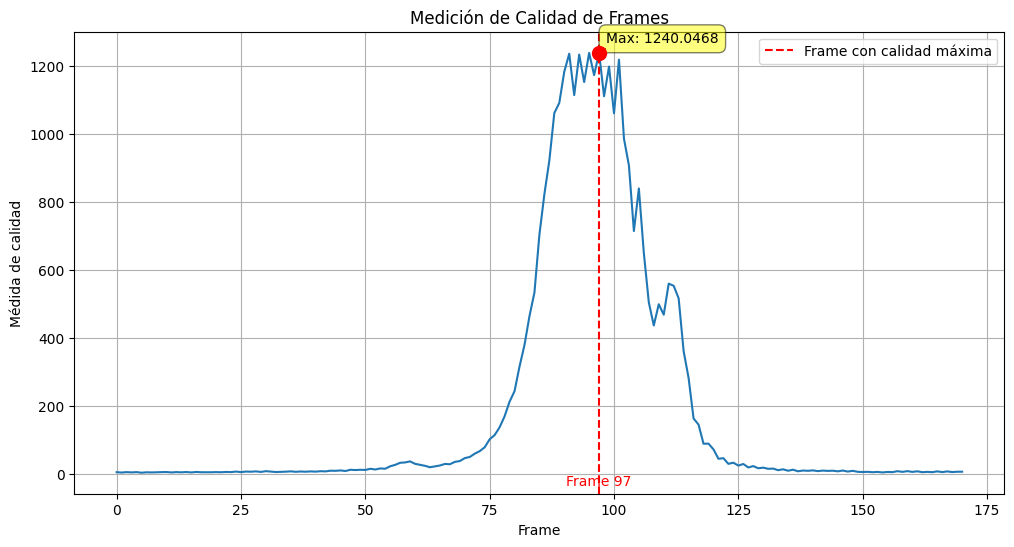

In [32]:
plot_quality_measures(measurements_with_roi)

Como porcentaje del punto central (10%)

In [33]:
roi_percentage = 0.10
measurements_with_roi, frame = process_video_roi(video_path, roi_percentage=roi_percentage, metric="LP")

In [34]:
print(f"Total de frames procesados: {len(measurements_with_roi)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_roi)
# Retorno del indice
max_focus_idx = measurements_with_roi.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx:.4f}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 613.5188
Alcanzado en el frame: 101.0000


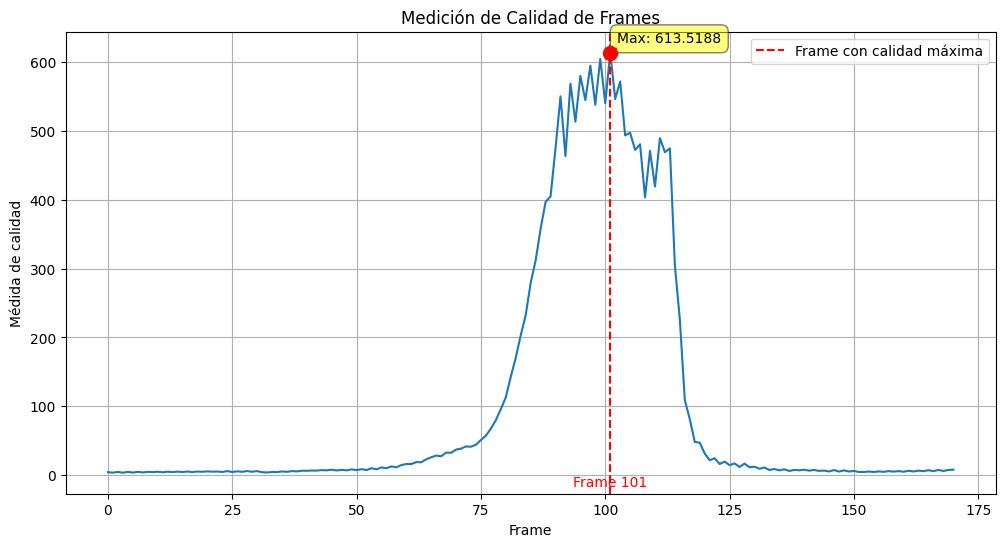

In [35]:
plot_quality_measures(measurements_with_roi)

# Medida del foco con una zona de interés

Medición sobre una matriz de dimensión NxM elementos rectangulares equiespaciados. **N** y **M** son valores arbitrarios, probar con varios valores **3x3**, **7x5**, etc … (al menos 3).

In [36]:
roi_size_1_1 = (3,3)
measurements_with_reticula_3x3_LP, frame = process_video_roi(video_path, roi_size=roi_size_1_1, metric="LP")

In [37]:
print(f"Total de frames procesados: {len(measurements_with_reticula_3x3_LP)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_3x3_LP)
# Retorno del indice
max_focus_idx = measurements_with_reticula_3x3_LP.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 6615.3333
Alcanzado en el frame: 81


In [38]:
roi_size_2_1 = (7,5)
measurements_with_reticula_7x5_LP, frame = process_video_roi(video_path, roi_size=roi_size_2_1, metric="LP")

In [39]:
print(f"Total de frames procesados: {len(measurements_with_reticula_7x5_LP)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_7x5_LP)
# Retorno del indice
max_focus_idx = measurements_with_reticula_7x5_LP.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 3740.2449
Alcanzado en el frame: 82


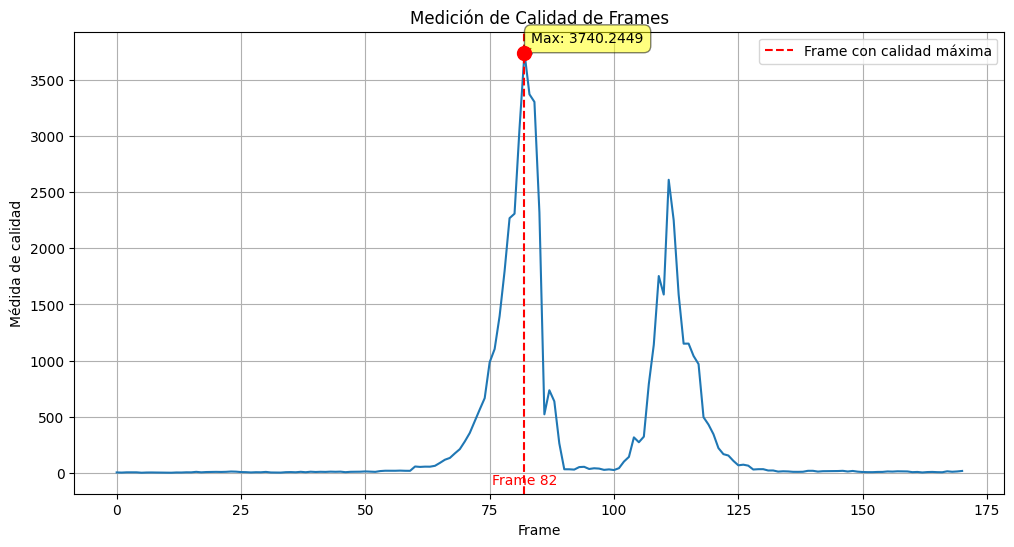

In [40]:
plot_quality_measures(measurements_with_reticula_7x5_LP)

In [41]:
roi_size_3_1 = (7,5)
measurements_with_reticula_9x12_LP, frame = process_video_roi(video_path, roi_size=roi_size_3_1, metric="LP")

In [42]:
print(f"Total de frames procesados: {len(measurements_with_reticula_9x12_LP)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_9x12_LP)
# Retorno del indice
max_focus_idx = measurements_with_reticula_9x12_LP.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 3740.2449
Alcanzado en el frame: 82


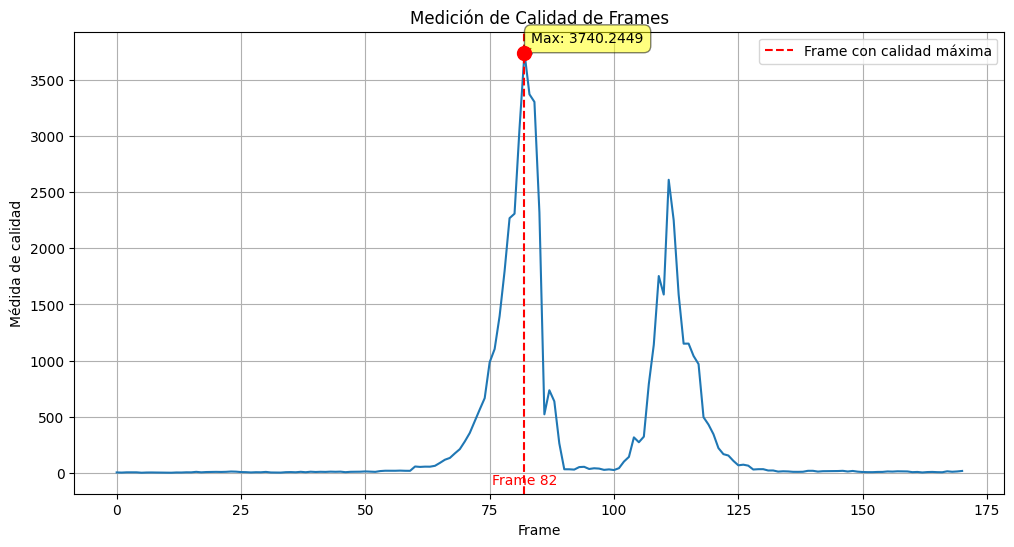

In [43]:
plot_quality_measures(measurements_with_reticula_9x12_LP)

In [44]:
roi_size_4_1 = (25,20)
measurements_with_reticula_25x20_LP, frame = process_video_roi(video_path, roi_size=roi_size_4_1, metric="LP")

In [45]:
print(f"Total de frames procesados: {len(measurements_with_reticula_25x20_LP)}")
# Busqueda del mayor valor
max_focus_val = max(measurements_with_reticula_25x20_LP)
# Retorno del indice
max_focus_idx = measurements_with_reticula_25x20_LP.index(max_focus_val)

print("===================================================")
print("Sumario de resultados")
print("===================================================")

print(f"Total de frames: {frame}")
print(f"Valor máximo de la métrica: {max_focus_val:.4f}")
print(f"Alcanzado en el frame: {max_focus_idx}")

print("===================================================")

Total de frames procesados: 171
Sumario de resultados
Total de frames: 171
Valor máximo de la métrica: 1403.1911
Alcanzado en el frame: 97


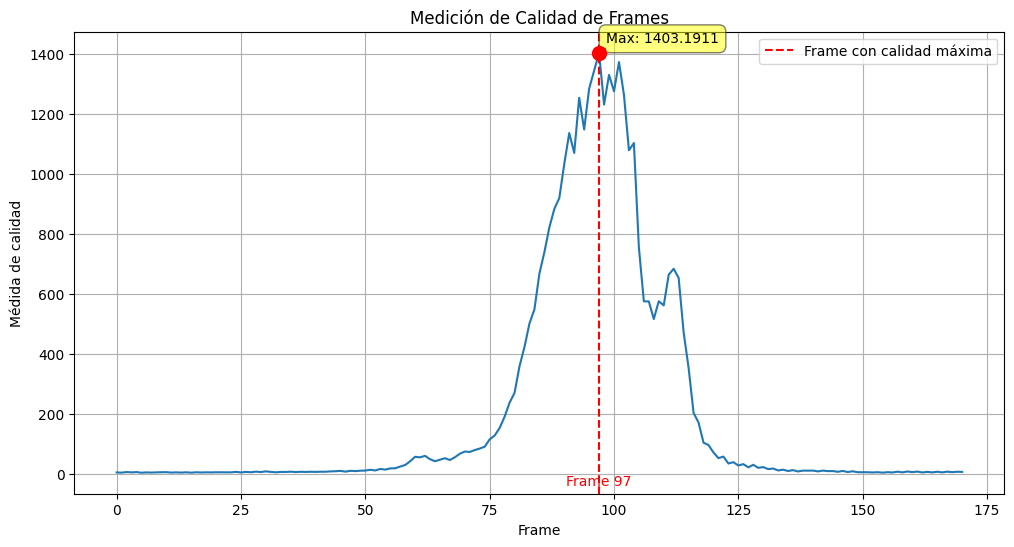

In [46]:
plot_quality_measures(measurements_with_reticula_25x20_LP)

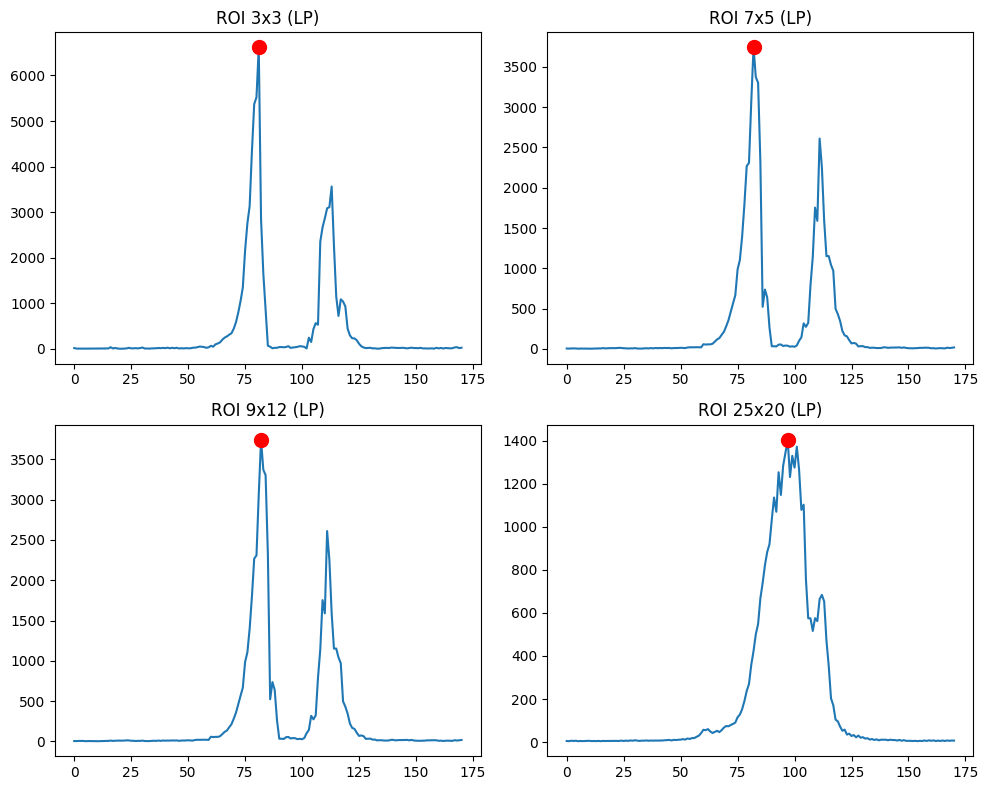

In [47]:
data = [measurements_with_reticula_3x3_LP, measurements_with_reticula_7x5_LP, \
        measurements_with_reticula_9x12_LP, measurements_with_reticula_25x20_LP]
max_value = [max(i) for i in data]
max_frame = [i.index(m) for i, m in zip(data, max_value)]

# Preparación del figure para el gráfico
fig, ax = plt.subplots(2,2, figsize=(10, 8))

ax[0, 0].plot(range(171), measurements_with_reticula_3x3_LP)
ax[0, 0].scatter(max_frame[0], max_value[0], color='red', s=100, zorder=5)
ax[0, 0].set_title("ROI 3x3 (LP)")
ax[0, 1].plot(range(171), measurements_with_reticula_7x5_LP)
ax[0, 1].scatter(max_frame[1], max_value[1], color='red', s=100, zorder=5)
ax[0, 1].set_title("ROI 7x5 (LP)")
ax[1, 0].plot(range(171), measurements_with_reticula_9x12_LP)
ax[1, 0].scatter(max_frame[2], max_value[2], color='red', s=100, zorder=5)
ax[1, 0].set_title("ROI 9x12 (LP)")
ax[1, 1].plot(range(171), measurements_with_reticula_25x20_LP)
ax[1, 1].scatter(max_frame[3], max_value[3], color='red', s=100, zorder=5)
ax[1, 1].set_title("ROI 25x20 (LP)")

plt.tight_layout()

plt.show()
